**Last Updated**: *18 April 2025*

**Part I: Preparing data**

In [1]:
# === Modules ===
import numpy as np
import torch
import torch.nn as nn # nn models
import torch.optim as optim # optimization algorithms (incl. stocastic gradient descend)
import torch.nn.functional as F # activation functions (incl. ReLu)
from torch.utils.data import TensorDataset, DataLoader, Subset, random_split, ConcatDataset, WeightedRandomSampler # dataset management
from torchvision.transforms import v2 # transformations (inc. random rotation)
import random
import time
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import optuna
from optuna import trial
from optuna.trial import TrialState

In [2]:
# === Functions: Spliting & Data augmentation ===

# Data spliting 
def split_dataset(base_dataset, cd_ids, val_perc=0.2, test_perc=0.2, random_seed=42):
    
    id_to_indices = {id_: [] for id_ in np.unique(cd_ids)}
    for i, id_ in enumerate(cd_ids):
        id_to_indices[id_].append(i)
    random.seed(random_seed)
    id_list = list(id_to_indices.keys())
    random.shuffle(id_list)

    n = len(id_list)
    val_n = int(val_perc * n)
    test_n = int(test_perc * n)

    val_ids = id_list[:val_n]
    test_ids = id_list[val_n:val_n + test_n]
    train_ids = id_list[val_n + test_n:]

    val_idx = [i for id_ in val_ids for i in id_to_indices[id_]]
    test_idx = [i for id_ in test_ids for i in id_to_indices[id_]]
    train_idx = [i for id_ in train_ids for i in id_to_indices[id_]]

    return Subset(base_dataset, train_idx), Subset(base_dataset, val_idx), Subset(base_dataset, test_idx)

# Data augmentation
augment_transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),         # horizontal flip with a prob of 50%
    v2.RandomVerticalFlip(p=0.5),           # vertival flip with a prob of 50%
    v2.RandomRotation(degrees=(90, 270))])  # random rotation between 90° and 270°  

class augment_dataset():
    def __init__(self, base_dataset, transform, n_augments=5):
        self.base_dataset = base_dataset
        self.transform = transform
        self.n_augments = n_augments

    def __len__(self):
        return len(self.base_dataset) * (1 + self.n_augments)

    def __getitem__(self, idx):
        base_idx = idx // (1 + self.n_augments)  
        augmentation_idx = idx % (1 + self.n_augments)

        x, y = self.base_dataset[base_idx]

        if augmentation_idx == 0: 
            return x, y
        else:  
            x_aug = self.transform(x)
            return x_aug, y

        
# Plot one example
def plot_dem_with_augmentations(dataset, sample_idx, n_augments=5, transform=augment_transform):
    original_img, _ = dataset[sample_idx]  
    dem_band = original_img[0]

    fig, axes = plt.subplots(1, n_augments + 1, figsize=(10, 3))

    vmin, vmax = dem_band.min().item(), dem_band.max().item()

    axes[0].imshow(dem_band.numpy(), cmap="terrain", vmin=vmin, vmax=vmax)
    axes[0].set_title("Original")
    axes[0].axis("off")

    for i in range(n_augments):
        augmented_img = transform(original_img) 
        augmented_dem = augmented_img[0]

        axes[i + 1].imshow(augmented_dem.numpy(), cmap="terrain", vmin=vmin, vmax=vmax)
        axes[i + 1].set_title(f"Aug {i + 1}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

In [3]:
# === Load data ===

# Load .npy files
non_cd_data = np.load('test_area_non_CD_featuresb.npy')
non_cd_labels = np.load('test_area_non_CD_labelsb.npy')
cd_data = np.load('test_area_CD_featuresb.npy')
cd_labels = np.load('test_area_CD_labelsb.npy')

# Remove aspect and edge
non_cd_data = np.delete(non_cd_data, [2, 3, 6], axis=1)
cd_data = np.delete(cd_data, [2, 3, 6], axis=1)

# Print basic info
print(f"{'':<15} {'Non-CD Data':<20} {'Non-CD Labels':<20} {'CD Data':<20} {'CD Labels':<20}")
print(f"{'Shape':<15} {str(non_cd_data.shape):<20} {str(non_cd_labels.shape):<20} {str(cd_data.shape):<20} {str(cd_labels.shape):<20}")
print(f"{'Dtype':<15} {str(non_cd_data.dtype):<20} {str(non_cd_labels.dtype):<20} {str(cd_data.dtype):<20} {str(cd_labels.dtype):<20}")
print(f"{'Range/Value':<15} {str(non_cd_data.min())+' - '+str(non_cd_data.max()):<20} {str(non_cd_labels.mean()):<20} {str(cd_data.min())+' - '+str(cd_data.max()):<20} {str(cd_labels.mean()):<20}")

                Non-CD Data          Non-CD Labels        CD Data              CD Labels           
Shape           (10000, 4, 50, 50)   (10000,)             (2138, 4, 50, 50)    (2138,)             
Dtype           float32              int32                float32              int32               
Range/Value     0.0 - 1.0            0.0                  0.0 - 1.0            1.0                 


                CD Data                        CD Labels                     
Shape           torch.Size([2138, 4, 50, 50])  torch.Size([2138])            


                               Training                       Validation                     Testing                       
Percentage of CD dataset       60%                            20%                            20%                           
Number of CDs                  1409                           378                            351                           
Number of augmented CDs        2818                           0                              0                             


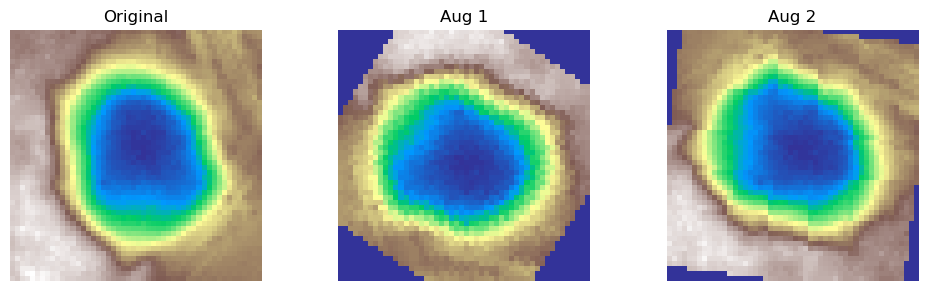

In [4]:
# === Prepare CD data ===

# Convert to torch tensors
cd_data_torch = torch.tensor(cd_data, dtype=torch.float32)
cd_labels_torch = torch.tensor(cd_labels, dtype=torch.long)
print(f"{'':<15} {'CD Data':<30} {'CD Labels':<30}")
print(f"{'Shape':<15} {str(cd_data_torch.shape):<30} {str(cd_labels_torch.shape):<30}")

base_dataset = TensorDataset(cd_data_torch, cd_labels_torch)

# Split into 60/20/20 for training/validation/testing
cd_ids = np.load("test_area_CD_id.npy") # split taking CD id into accound to avoid data leakage
val_perc = 0.2
test_perc = 0.2
train_dataset_cd, val_dataset_cd, test_dataset_cd = split_dataset(base_dataset, cd_ids, val_perc, test_perc)

# Perform data augmentation
n_augments = 5
augmented_train_dataset_cd = augment_dataset(train_dataset_cd, transform = augment_transform, n_augments=2)

# Print info 
print('\n')
print(f"{'':<30} {'Training':<30} {'Validation':<30} {'Testing':<30}")
print(f"{'Percentage of CD dataset':<30} {str(int((1-val_perc-test_perc)*100))+'%':<30} {str(int(val_perc*100))+'%':<30} {str(int(test_perc*100))+'%':<30}")
print(f"{'Number of CDs':<30} {str(len(train_dataset_cd)):<30} {str(len(val_dataset_cd)):<30} {str(len(test_dataset_cd)):<30}")
print(f"{'Number of augmented CDs':<30} {str(len(augmented_train_dataset_cd)-len(train_dataset_cd)):<30} {str('0'):<30} {str('0'):<30}")
plot_dem_with_augmentations(train_dataset_cd, sample_idx=10, n_augments=2)

In [5]:
# === Prepare Non-CD data ===

# Convert to torch tensors
non_cd_data_torch = torch.tensor(non_cd_data, dtype=torch.float32)
non_cd_labels_torch = torch.tensor(non_cd_labels, dtype=torch.long)
print(f"{'':<15} {'Non-CD Data':<30} {'Non-CD Labels':<30}")
print(f"{'Shape':<15} {str(non_cd_data_torch.shape):<30} {str(non_cd_labels_torch.shape):<30}")

negative_dataset = TensorDataset(non_cd_data_torch, non_cd_labels_torch)

# Split into 97/3/3 for training/validation/testing
val_perc_neg = 0.03
test_perc_neg = 0.03
total_neg = len(negative_dataset)
val_size_neg = int(val_perc_neg * total_neg)
test_size_neg = int(test_perc_neg * total_neg)
train_size_neg = total_neg - val_size_neg - test_size_neg

train_dataset_non_cd, val_dataset_non_cd, test_dataset_non_cd = random_split(negative_dataset, 
                                                                    [train_size_neg, val_size_neg, test_size_neg], 
                                                                    generator=torch.Generator().manual_seed(42))

# Print info
print('\n')
print(f"{'':<30} {'Training':<30} {'Validation':<30} {'Testing':<30}")
print(f"{'Percentage of non-CD dataset':<30} {str(int((1-val_perc_neg-test_perc_neg)*100))+'%':<30} {str(int(val_perc_neg*100))+'%':<30} {str(int(test_perc_neg*100))+'%':<30}")
print(f"{'Number of non-CDs':<30} {str(len(train_dataset_non_cd)):<30} {str(len(val_dataset_non_cd)):<30} {str(len(test_dataset_non_cd)):<30}")

                Non-CD Data                    Non-CD Labels                 
Shape           torch.Size([10000, 4, 50, 50]) torch.Size([10000])           


                               Training                       Validation                     Testing                       
Percentage of non-CD dataset   94%                            3%                             3%                            
Number of non-CDs              9400                           300                            300                           


In [6]:
# === Functions: Data loaders ===
def get_data_loaders(final_train_dataset, final_val_dataset, final_test_dataset):
    batch_size = 32
    
    # Compute class weights for sampler
    y_train = []
    for data in final_train_dataset:
        _, y = data
        y_train.append(y)
    y_train = torch.tensor(y_train)

    # Calculate class counts and weights
    class_counts = torch.bincount(y_train)
    class_weights = 1. / class_counts.float()
    sample_weights = class_weights[y_train]
    
    # Weighted random sampler for imbalanced data
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    # Create DataLoaders with samplers
    train_loader = DataLoader(final_train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(final_test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [7]:
# === Combine CD & Non-CD data ===

# Create DataLoaders
final_train_dataset = ConcatDataset([augmented_train_dataset_cd, train_dataset_non_cd])
final_val_dataset = ConcatDataset([val_dataset_cd, val_dataset_non_cd])
final_test_dataset = ConcatDataset([test_dataset_cd, test_dataset_non_cd])

print(f"{'':<30} {'Training':<30} {'Validation':<30} {'Testing':<30}")
print(f"{'Number of samples':<30} {str(len(final_train_dataset)):<30} {str(len(final_val_dataset)):<30} {str(len(final_test_dataset)):<30}")

                               Training                       Validation                     Testing                       
Number of samples              13627                          678                            651                           


**Part II: Training and validating 2D CNN**

In [8]:
# === Set device and parameters ===
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device will run on {device}")

Device will run on cuda


In [ ]:
# === Functions: CNN ===
class CNN(nn.Module):
    def __init__(self, trial, in_channels=4, num_classes=1):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
       
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global average pooling layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(256*1*1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, num_classes)

        # Dropout layers
        self.dropout = nn.Dropout(trial.suggest_float("dropout", 0.2, 0.5)) #  > 0.4 for robustness!

    def forward(self, x):
        # Convolutional layers with ReLU activation & batch normalization 
        # & Max pooling layers
        x = F.relu(self.bn1(self.conv1(x)))         # (batch, 32, 50, 50)
        x = F.relu(self.bn2(self.conv2(x)))         # (batch, 64, 50, 50)
        x = self.pool(x)                            # (batch, 64, 25, 25)
        
        x = F.relu(self.bn3(self.conv3(x)))         # (batch, 128, 25, 25)
        x = F.relu(self.bn4(self.conv4(x)))         # (batch, 256, 25, 25)
        x = self.pool(x)                            # (batch, 256, 12, 12)

        # Average pooling layer
        x = self.global_pool(x)                     # (batch, 256, 1, 1)
        
        # Flatten
        x = torch.flatten(x, 1)                     # (batch, 256)

        # Fully connected layers with ReLU activation 
        # & Dropout layers
        x = self.dropout(F.relu(self.fc1(x)))      # (batch, 128)
        x = self.dropout(F.relu(self.fc2(x)))      # (batch, 64)
        x = self.output(x)                         # (batch, 1)

        return x

In [ ]:
def objective(trial):
    # Get the CNN model
    model = CNN(trial).to(device)

    # Hyperparameter suggestions
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]) # remove from optimization
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    threshold = trial.suggest_float("threshold", 0.3, 0.7)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    n_epochs = trial.suggest_int("n_epochs", 10, 50)
    
    # Load data
    train_loader, valid_loader, _ = get_data_loaders(final_train_dataset, final_val_dataset, final_test_dataset)

    # Compute class weights
    train_labels = torch.cat([target for _, target in train_loader], dim=0)
    pos_count = (train_labels == 1).sum().item()
    neg_count = (train_labels == 0).sum().item()
    pos_weight = torch.tensor([neg_count / pos_count]).to(device)

    # Weighted binary classification loss
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_f1 = 0
    best_model_state = None

    for epoch in range(n_epochs):
        # Training
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device).float()
            output = model(data).squeeze(1)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        all_preds, all_targets = [], []

        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device).float()
                output = model(data).squeeze(1)
                probs = torch.sigmoid(output)
                preds = (probs >= threshold).long()

                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        # Compute F1 score
        f1 = f1_score(all_targets, all_preds, zero_division=0)

        # Report to Optuna
        trial.report(f1, epoch)
        # print out other metrics!
        
        # Save model if it's the best so far
        if f1 > best_f1:
            best_f1 = f1
            best_model_state = model.state_dict()
        # + save trial
        # Early pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Save best model to file
    if best_model_state is not None:
        model_path = f"best_model_trial_{trial.number}.pt"
        torch.save(best_model_state, model_path)
        trial.set_user_attr("best_f1", best_f1)
        trial.set_user_attr("model_path", model_path)

    return best_f1

In [12]:
# === Optuna study ===
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize", study_name="2d-cnn")
    study.optimize(objective, n_trials=100)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

best_trial = study.best_trial
print("\nStudy summary:")
print(f"  Finished trials     : {len(study.trials)}")
print(f"  Pruned trials       : {len(pruned_trials)}")
print(f"  Completed trials    : {len(complete_trials)}")
print(f"\nBest Trial #{best_trial.number}")
print(f"  Best F1 score       : {best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key:<15}: {value}")

[I 2025-04-21 02:24:09,312] A new study created in memory with name: 2d-cnn
[I 2025-04-21 02:53:18,499] Trial 0 finished with value: 0.826629680998613 and parameters: {'dropout': 0.27197663142745826, 'optimizer': 'Adam', 'lr': 0.012667116144181655, 'threshold': 0.6063605653208981, 'n_epochs': 35}. Best is trial 0 with value: 0.826629680998613.
[I 2025-04-21 03:12:04,455] Trial 1 finished with value: 0.7694524495677233 and parameters: {'dropout': 0.43141579347390435, 'optimizer': 'RMSprop', 'lr': 0.0004250252009418519, 'threshold': 0.5856697172179299, 'n_epochs': 22}. Best is trial 0 with value: 0.826629680998613.
[I 2025-04-21 03:48:12,646] Trial 2 finished with value: 0.8147100424328148 and parameters: {'dropout': 0.30020330379199467, 'optimizer': 'SGD', 'lr': 0.00422476927742103, 'threshold': 0.5593570876112246, 'n_epochs': 42}. Best is trial 0 with value: 0.826629680998613.
[I 2025-04-21 04:04:42,610] Trial 3 finished with value: 0.8232118758434548 and parameters: {'dropout': 0.2788


Study summary:
  Finished trials     : 100
  Pruned trials       : 64
  Completed trials    : 36

Best Trial #91
  Best F1 score       : 0.8980
  Best hyperparameters:
    dropout        : 0.26906734129878085
    optimizer      : Adam
    lr             : 0.005827299064657496
    threshold      : 0.3155485006760434
    n_epochs       : 27


In [13]:
optuna.visualization.plot_param_importances(study)

In [14]:
optuna.visualization.plot_optimization_history(study, target_name="f1")

In [15]:
best_trial = study.best_trial
best_model = CNN(best_trial).to(device)
best_model.load_state_dict(torch.load(best_trial.user_attrs["model_path"]))

NameError: name 'study' is not defined

**Part III: Testing 2D CNN**

In [ ]:
# === Test the model ===
best_model = CNN(best_trial).to(device)
best_model.load_state_dict(torch.load(best_trial.user_attrs["model_path"]))
best_model.eval()

_, _, test_loader = get_data_loaders(final_train_dataset, final_val_dataset, final_test_dataset)

all_preds, all_probs, all_targets = [], [], []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data).squeeze(1)
        probs = torch.sigmoid(output)

        preds = (probs >= threshold).long()

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

precision = precision_score(all_targets, all_preds, zero_division=0)
recall = recall_score(all_targets, all_preds, zero_division=0)
f1 = f1_score(all_targets, all_preds, zero_division=0)

all_probs_flat = [float(p[0]) for p in all_probs]
precision_curve, recall_curve, _ = precision_recall_curve(all_targets, all_probs_flat)
pr_auc = auc(recall_curve, precision_curve)



In [ ]:
# === Baseline === ???

class baseline_CNN(nn.Module):
    def __init__(self, input_channels=1, image_size=28):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Reduces spatial size by half
        )
        flattened_size = 8 * (image_size // 2) * (image_size // 2)
        self.fc = nn.Linear(flattened_size, 1)  # Binary classification

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

def train_shallow_cnn(train_loader, val_loader, device, n_epochs=10, lr=1e-3):
    model = baseline_CNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Handle imbalance if needed
    train_labels = torch.cat([target for _, target in train_loader], dim=0)
    pos = (train_labels == 1).sum().item()
    neg = (train_labels == 0).sum().item()
    pos_weight = torch.tensor([neg / pos]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    for epoch in range(n_epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device).float()
            output = model(data).squeeze(1)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze(1)
            probs = torch.sigmoid(output)
            preds = (probs >= 0.5).long()

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    val_f1 = f1_score(all_targets, all_preds, zero_division=0)
    print(f"Baseline CNN Validation F1: {val_f1:.4f}")
    return model, val_f1
